Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

## tf.nn相关api的用法

### tf.nn.conv2d

``tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)``：
- input和filter都是4D的tensor类型，计算两者的2D卷积，input的shape为``[batch, in_height, in_width, in_channels]``，filter/kernel的shape为``[filter_height, filter_width, in_channels, out_channels]``
- strides为长度为4的列表，input的每个维度的滑动窗口的stride步长
- padding，使用的padding算法，"SAME"或者"VALID"，VALID卷积后比原来小，SAME卷积后和原来一样
- 步骤：
    - Flattens the filter to a 2-D matrix with shape ``[filter_height * filter_width * in_channels, output_channels]``.
    - Extracts image patches from the the input tensor to form a virtual tensor of shape ``[batch, out_height, out_width, filter_height * filter_width * in_channels]``.
    - For each patch, right-multiplies the filter matrix and the image patch vector.
``` python
output[b, i, j, k] =
    sum_{di, dj, q} input[b, strides[1] * i + di, strides[2] * j + dj, q] *
                    filter[di, dj, q, k]
```

### tf.nn.max_pool

``max_pool(value, ksize, strides, padding, data_format='NHWC', name=None)``：

- value: 4D tensor，shape为 ``[batch, height, width, channels]``
- ksize: 长度大于等于4的列表，表示输入tensor在各个维度的窗口size
- strides: 长度大于等于4的列表，表示输入tensor在各个维度的滑动步长stride
- padding: 'VALID'或者'SAME'
- data_format: 'NHWC' 和'NCHW'格式
- 返回一个tensor

In [5]:
# 测试一下
import tensorflow as tf

image = tf.Variable(tf.random_normal([10, 12, 12, 3]))
conv = tf.Variable(tf.random_normal([3, 3, 3, 7]))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(tf.nn.conv2d(image, conv, strides=[1, 5, 5, 1], padding="VALID")))

[[[[ -1.32466626  -6.67931557   3.07158041  -0.79612941  -2.98868632
     -2.47920966   1.30111063]
   [ -1.36639094  -2.20306778   2.79762554   7.16898346  -6.253438
     -0.02547812  -7.85903215]]

  [[-11.37894344  -0.62337959  -4.51255751   4.38367271 -10.02955341
    -11.74923229   1.59372163]
   [  3.86116028   5.47299147   1.10483146  -2.2462368   -7.94320345
     -0.8984862    9.9844532 ]]]


 [[[ -0.3932023   -6.04491282   1.42640388  -5.33213234   7.27532339
     -1.76176012   1.76966786]
   [  4.54447842  -2.88046432  -5.06158876  -2.21337461  -1.02330899
      6.80932951  -5.82551861]]

  [[  7.53678608   5.62770891  -6.52420473  -2.59522915  -5.59924173
      3.94188547 -12.94682312]
   [  2.2645824    3.34572792   3.89495754  -3.47028446  -4.54277134
     -3.04720068   9.48500538]]]


 [[[  1.90466952   2.41149259   6.1916008    3.47495341  -1.28297651
     -6.33309937   0.34712839]
   [ -7.93357468  -0.87230706  -7.81025362   2.51702929  -5.04481602
      0.37983584   8.

In [6]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [7]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.889615
Minibatch accuracy: 6.2%
Validation accuracy: 12.3%
Minibatch loss at step 50: 1.874982
Minibatch accuracy: 31.2%
Validation accuracy: 37.1%
Minibatch loss at step 100: 0.661359
Minibatch accuracy: 75.0%
Validation accuracy: 62.5%
Minibatch loss at step 150: 0.715556
Minibatch accuracy: 81.2%
Validation accuracy: 73.6%
Minibatch loss at step 200: 0.992048
Minibatch accuracy: 62.5%
Validation accuracy: 73.6%
Minibatch loss at step 250: 0.292988
Minibatch accuracy: 93.8%
Validation accuracy: 76.8%
Minibatch loss at step 300: 0.677129
Minibatch accuracy: 81.2%
Validation accuracy: 78.5%
Minibatch loss at step 350: 0.867434
Minibatch accuracy: 68.8%
Validation accuracy: 79.1%
Minibatch loss at step 400: 0.710968
Minibatch accuracy: 81.2%
Validation accuracy: 79.2%
Minibatch loss at step 450: 0.226031
Minibatch accuracy: 100.0%
Validation accuracy: 79.8%
Minibatch loss at step 500: 0.703758
Minibatch accuracy: 75.0%
Validation accuracy: 79.6%
M

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

在上述CNN网络中加入步长stride为2和kernel size为2的max pooling

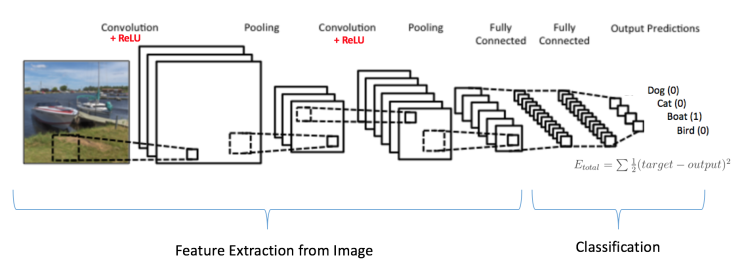

In [11]:
display(Image("ConvNet.jpg"))

In [16]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model with Max Pooling
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') # update stride as 1
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME') # add max pooling
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME') # update stride as 1
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME') # add max pooling
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [21]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.217397
Minibatch accuracy: 6.2%
Validation accuracy: 10.2%
Minibatch loss at step 500: 0.567970
Minibatch accuracy: 75.0%
Validation accuracy: 81.4%
Minibatch loss at step 1000: 0.269530
Minibatch accuracy: 87.5%
Validation accuracy: 84.0%
Minibatch loss at step 1500: 0.404251
Minibatch accuracy: 81.2%
Validation accuracy: 85.3%
Minibatch loss at step 2000: 0.741879
Minibatch accuracy: 81.2%
Validation accuracy: 85.9%
Minibatch loss at step 2500: 0.048788
Minibatch accuracy: 100.0%
Validation accuracy: 86.0%
Minibatch loss at step 3000: 0.787112
Minibatch accuracy: 75.0%
Validation accuracy: 86.7%
Test accuracy: 93.1%


---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

参考LeNet-5结构，加入Dropout和学习率衰减

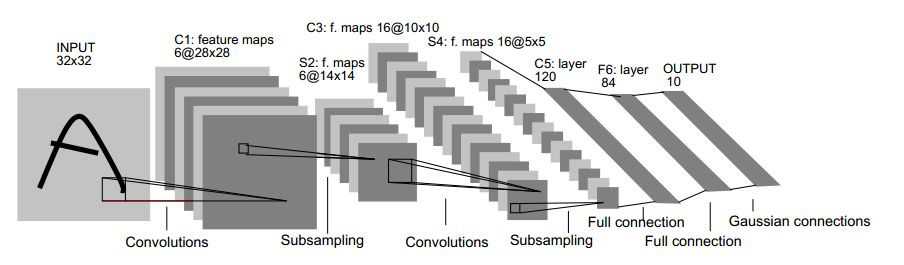

In [10]:
from IPython.display import display, Image

display(Image("LeNet-5.jpg"))